In [1]:
import numpy as np
import random as rd
import pandas as pd
import sys
sys.path.insert(0, '../src/model/')
sys.path.insert(1, '../src/view/')
from Taixxa import Taixxa
from FitnessViewer import FitnessViewer
from FitnessComparator import FitnessComparator

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 1 Axes>

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


<Figure size 432x288 with 0 Axes>

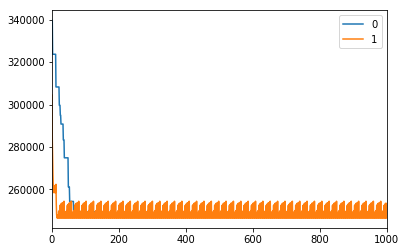

In [4]:
data = Taixxa()
data.loadFile("tai12a.dat")
data2 = Taixxa()
data2.loadFile("tai12a.dat")
data3 = Taixxa()
data3.loadFile("tai12a.dat")
data4 = Taixxa()
data4.loadFile("tai12a.dat")
sol, fit1 = data.simulatedAnnealing(30, 0.9,100,11)
sol, fit2 = data2.tabuSearch(1000, 10)
fit1 = np.array(fit1)
fit2 = np.array(fit2)

lists = list([fit1,fit2])
df = pd.concat([pd.Series(x) for x in lists], axis=1)
comp = FitnessComparator(df)
comp.plot()

In [5]:
solPerfect = [8,1,6,2,11,10,3,5,9,7,12,4]
solPerfect = list(map(lambda x: x-1, solPerfect))
mincost = data.computeCost(solPerfect)
mincostfound = data.computeCost()
mincostfound2 = data2.computeCost()
print(mincost)
print(mincostfound)
print(mincostfound2)

224416
247294
246614
